# 运行YOLO分类模型，给数据分类

## 分类，导出结果

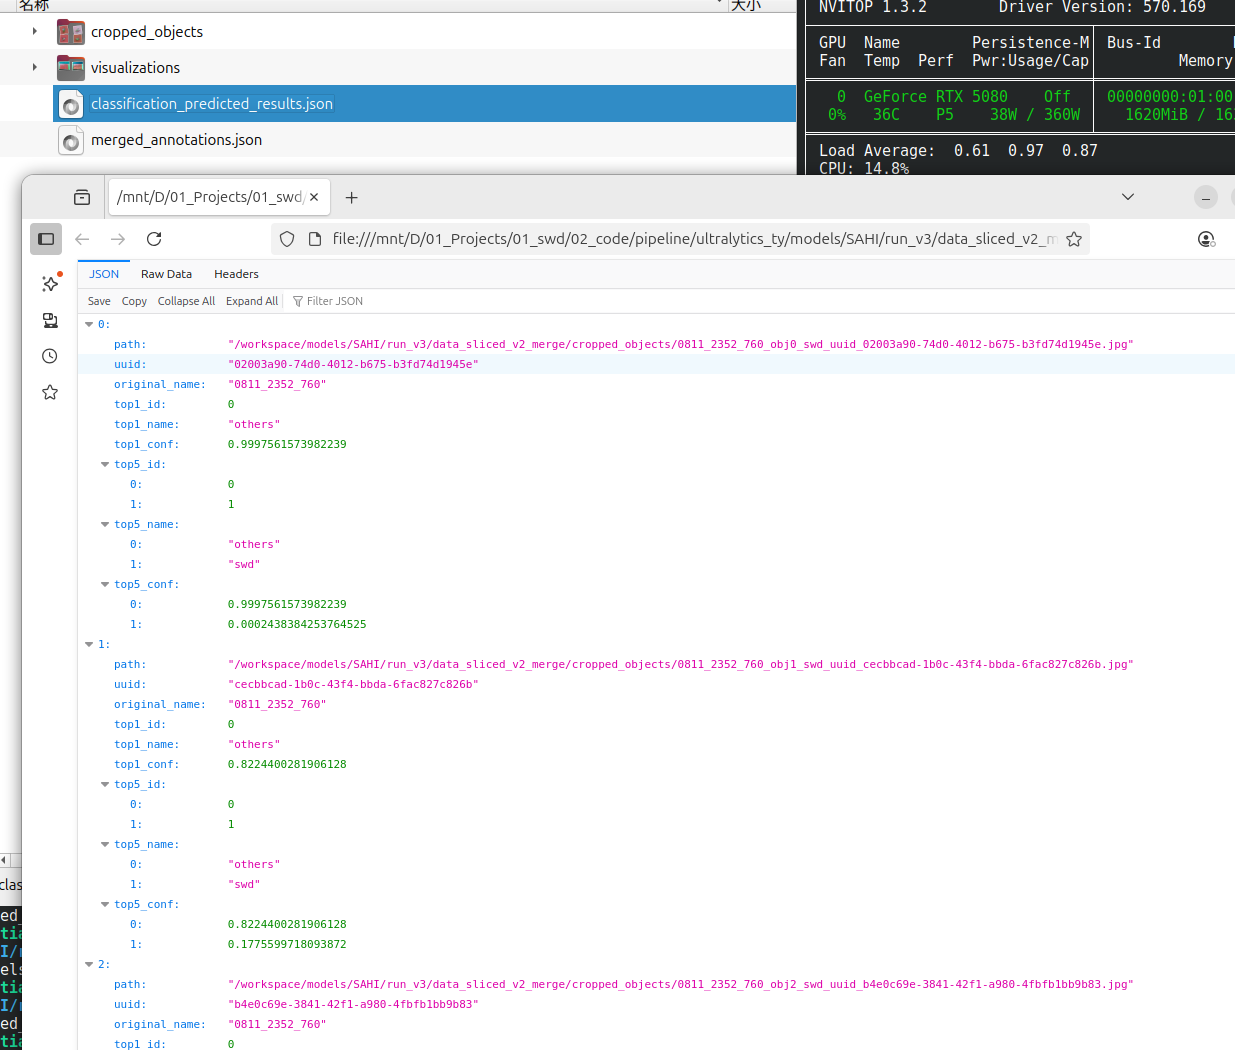

In [ ]:
# ==== 配置 ====
MODEL_PATH = "/workspace/models/best_model/yolo11s-cls-best.pt"
INPUT_DIR  = "/workspace/models/SAHI/run_v3/data_sliced_v2_merge/cropped_objects/"
OUTPUT_JSON = "/workspace/models/SAHI/run_v3/data_sliced_v2_merge/classification_predicted_results.json"


import os
import re
import json
from collections import Counter
from ultralytics import YOLO

# 解析文件名的正则表达式
UUID_RE = re.compile(r"uuid_([a-f0-9\-]+)\.jpg", re.IGNORECASE)
ORIG_RE = re.compile(r"^(\d+_\d+_\d+)_obj", re.IGNORECASE)

def get_probs_fields(res, name_map):
    """安全获取 top1/top5 字段（缺失时给空值/空列表）。"""
    probs = getattr(res, "probs", None)
    if probs is None:
        return None, None, None, [], [], []

    # top1
    try:
        top1_id = int(probs.top1)
    except Exception:
        top1_id = None
    top1_name = name_map.get(top1_id) if top1_id is not None else None

    # top1 conf
    try:
        top1_conf = float(getattr(probs.top1conf, "item", lambda: probs.top1conf)())
    except Exception:
        top1_conf = None

    # top5
    try:
        top5_id = [int(x) for x in list(probs.top5)]
    except Exception:
        top5_id = []
    top5_name = [name_map.get(i, str(i)) for i in top5_id]
    try:
        top5_conf = [float(x) for x in list(probs.top5conf)]
    except Exception:
        top5_conf = []

    return top1_id, top1_name, top1_conf, top5_id, top5_name, top5_conf


# ==== 主流程 ====
if __name__ == "__main__":
    # 1) 加载模型
    model = YOLO(MODEL_PATH)
    class_names = model.names  # dict: {0: "...", 1: "..."}

    # 2) 执行预测（Ultralytics 支持目录）
    results = model(INPUT_DIR)

    data = []
    counts = Counter()

    for res in results:
        path = getattr(res, "path", "")
        fname = os.path.basename(path)

        # 提取 uuid / 原图名
        uuid_match = UUID_RE.search(fname)
        uuid_str = uuid_match.group(1) if uuid_match else None
        orig_match = ORIG_RE.match(fname)
        original_name = orig_match.group(1) if orig_match else None

        # 概率字段
        top1_id, top1_name, top1_conf, top5_id, top5_name, top5_conf = get_probs_fields(res, class_names)
        if top1_id is not None:
            counts[top1_id] += 1

        # 记录一条
        data.append({
            "path": path,
            "uuid": uuid_str,
            "original_name": original_name,
            "top1_id": top1_id,
            "top1_name": top1_name,
            "top1_conf": top1_conf,
            "top5_id": top5_id,
            "top5_name": top5_name,
            "top5_conf": top5_conf,
        })

    # 3) 打印统计
    print("分类统计结果：")
    for cls_id, num in counts.items():
        print(f"{class_names.get(cls_id, cls_id)}: {num}")
    total = sum(counts.values())
    print(f"总计: {total}")

    # 4) 保存 JSON（保持与你原来一致的结构）
    with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

    print(f"✅ 已保存到 {OUTPUT_JSON}")



image 1/6 /workspace/models/SAHI/run_v3/data_sliced_v2_merge/cropped_objects/0811_2352_760_obj0_swd_uuid_02003a90-74d0-4012-b675-b3fd74d1945e.jpg: 64x64 others 1.00, swd 0.00, 2.0ms
image 2/6 /workspace/models/SAHI/run_v3/data_sliced_v2_merge/cropped_objects/0811_2352_760_obj1_swd_uuid_cecbbcad-1b0c-43f4-bbda-6fac827c826b.jpg: 64x64 others 0.82, swd 0.18, 1.5ms
image 3/6 /workspace/models/SAHI/run_v3/data_sliced_v2_merge/cropped_objects/0811_2352_760_obj2_swd_uuid_b4e0c69e-3841-42f1-a980-4fbfb1bb9b83.jpg: 64x64 others 1.00, swd 0.00, 1.3ms
image 4/6 /workspace/models/SAHI/run_v3/data_sliced_v2_merge/cropped_objects/0811_2352_760_obj3_swd_uuid_4b1ffdb0-3935-4545-a8fd-891464df6a5d.jpg: 64x64 others 1.00, swd 0.00, 1.3ms
image 5/6 /workspace/models/SAHI/run_v3/data_sliced_v2_merge/cropped_objects/0812_1838_800_obj0_swd_uuid_c050506b-d07f-416f-a1fc-3dacb2eee4d1.jpg: 64x64 others 1.00, swd 0.00, 1.3ms
image 6/6 /workspace/models/SAHI/run_v3/data_sliced_v2_merge/cropped_objects/0812_1838_80

## 展示预测后部分图片

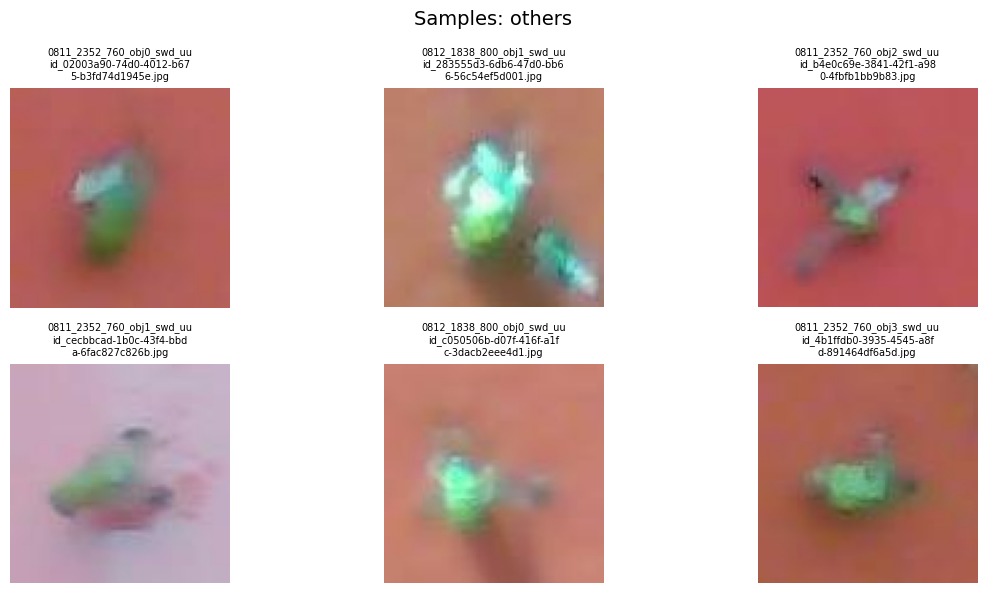

In [16]:
import matplotlib.pyplot as plt
import random
import os

def wrap_text(text, width=30):
    """给长字符串自动换行"""
    return "\n".join([text[i:i+width] for i in range(0, len(text), width)])

def show_samples(target_class: str, num_samples: int = 6):
    images = [d["path"] for d in data if d["top1_name"] == target_class]
    if not images:
        print(f"❌ 没有找到类别 {target_class}")
        return
    
    samples = random.sample(images, min(num_samples, len(images)))

    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(samples, 1):
        plt.subplot(2, 3, i)
        plt.imshow(plt.imread(img_path))
        fname = os.path.basename(img_path)
        plt.title(wrap_text(fname, 25), fontsize=7)  # 每25字符换行
        plt.axis("off")

    plt.suptitle(f"Samples: {target_class}", fontsize=14)
    plt.tight_layout()
    plt.show()


# 示例：展示 "xxx" 的部分图片
show_samples("others", num_samples=6)

# 